In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM, GRU, BatchNormalization, Dropout

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical, pad_sequences

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder

from data_augmentation import Augmenter

NUM_POINTS = 50

In [2]:
data = []

for root, subdirs, files in os.walk('dataset'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in files:
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                data.append((label, points))

In [3]:
augmenter = Augmenter(gestures=data)

In [4]:
training_set = augmenter.get_avc_set()

In [5]:
labels = [sample[0] for sample in training_set]
print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

print(set(labels_encoded))
y = to_categorical(labels_encoded)
print(len(y[0]))

sequences = [sample[1] for sample in training_set]
sequences = pad_sequences(
    sequences, padding="pre", dtype='float32'
)
X = np.array(sequences)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'arrow', 'caret', 'check'}
{0, 1, 2}
3
(4915, 127, 2) (1229, 127, 2) (4915, 3) (1229, 3)


In [6]:
# Define the model
model = Sequential()

model.add(GRU(64, dropout=0.03)) # 96?
# model.add(GRU(96, dropout=0.03))

model.add(BatchNormalization())
model.add(Dropout(.3)) # input shape?
model.add(Dense(64))

model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(Dense(32))

model.add(BatchNormalization())
model.add(Dropout(.25))
model.add(Dense(3))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [7]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=10,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/20
492/492 [==============================] - 18s 31ms/step - loss: 3.3819 - accuracy: 0.3270 - val_loss: 1.5366 - val_accuracy: 0.4239 - lr: 0.0010
Epoch 2/20
492/492 [==============================] - 15s 31ms/step - loss: 2.2399 - accuracy: 0.3709 - val_loss: 1.3273 - val_accuracy: 0.3198 - lr: 0.0010
Epoch 3/20
492/492 [==============================] - 15s 31ms/step - loss: 1.8693 - accuracy: 0.3388 - val_loss: 1.1054 - val_accuracy: 0.3149 - lr: 0.0010
Epoch 4/20
492/492 [==============================] - 16s 32ms/step - loss: 1.7742 - accuracy: 0.3198 - val_loss: 1.1079 - val_accuracy: 0.3124 - lr: 0.0010
Epoch 5/20
492/492 [==============================] - 15s 31ms/step - loss: 1.7093 - accuracy: 0.3261 - val_loss: 1.0862 - val_accuracy: 0.3629 - lr: 0.0010
Epoch 6/20
492/492 [==============================] - 15s 30ms/step - loss: 1.6015 - accuracy: 0.3296 - val_loss: 1.0885 - val_accuracy: 0.2164 - lr: 0.0010
Epoch 7/20
492/492 [==============================] - 15s 

In [19]:
# Define the model
model = Sequential()

    # add LSTM layer
    # input shape is (length of an individual sample, dimensions of the sample)
    # in our case: two dimensions, as we have X and Y coordinates
model.add(LSTM(96, input_shape=(129, 2)))

    # add dense layer to do machine learning magic
#model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
    # here, you can add more layers and maybe a dropout for better performance

    # softmax layer for classification
model.add(Dense(len(set(labels)), activation='softmax'))

    # Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)
    
    # Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/20
10/10 [==============================] - 17s 1s/step - loss: 1.0887 - accuracy: 0.3902 - val_loss: 1.0203 - val_accuracy: 0.5810 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 15s 1s/step - loss: 0.9898 - accuracy: 0.5959 - val_loss: 0.9342 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 15s 2s/step - loss: 0.9099 - accuracy: 0.6383 - val_loss: 0.8425 - val_accuracy: 0.7046 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 15s 1s/step - loss: 0.8038 - accuracy: 0.6924 - val_loss: 0.7113 - val_accuracy: 0.7592 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - 15s 1s/step - loss: 0.6625 - accuracy: 0.7495 - val_loss: 0.5784 - val_accuracy: 0.7893 - lr: 0.0010
Epoch 6/20
10/10 [==============================] - 15s 2s/step - loss: 0.5429 - accuracy: 0.8092 - val_loss: 0.4738 - val_accuracy: 0.8446 - lr: 0.0010
Epoch 7/20
10/10 [==============================] - 14s 1s/step - loss: 0.4511 - a

In [20]:
model.save('gesture_recognition')
model.summary()

INFO:tensorflow:Assets written to: gesture_recognition\assets


INFO:tensorflow:Assets written to: gesture_recognition\assets


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 96)                38016     
                                                                 
 dense_12 (Dense)            (None, 64)                6208      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 3)                 99        
                                                                 
Total params: 46,403
Trainable params: 46,403
Non-trainable params: 0
_________________________________________________________________


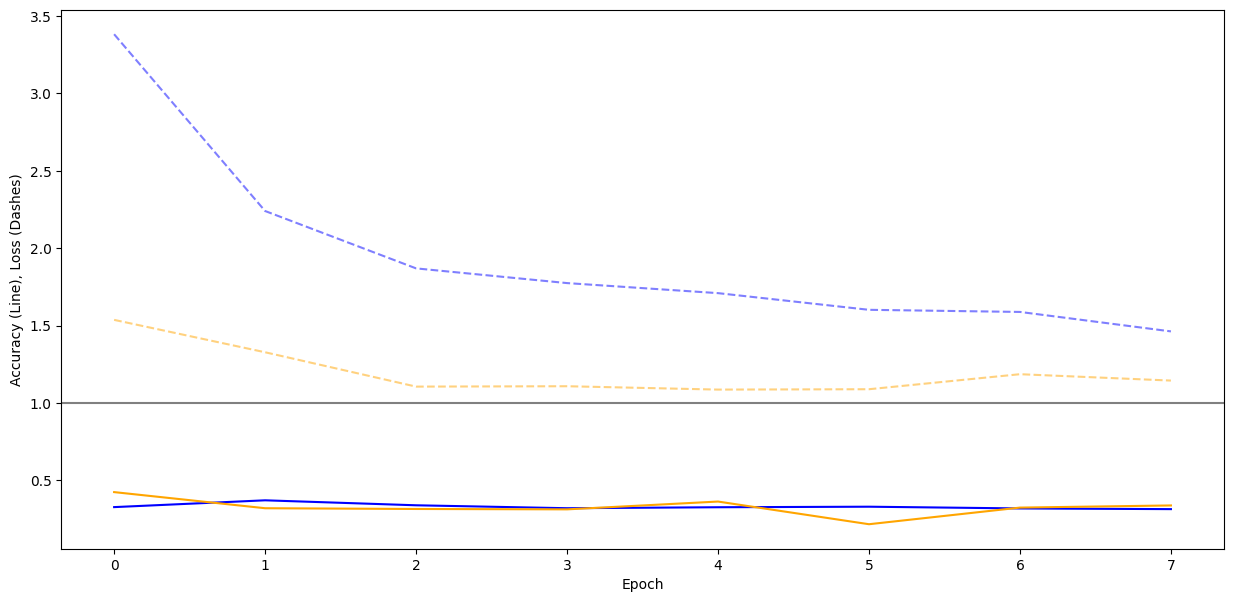

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

39/39 [==============================] - 0s 8ms/step


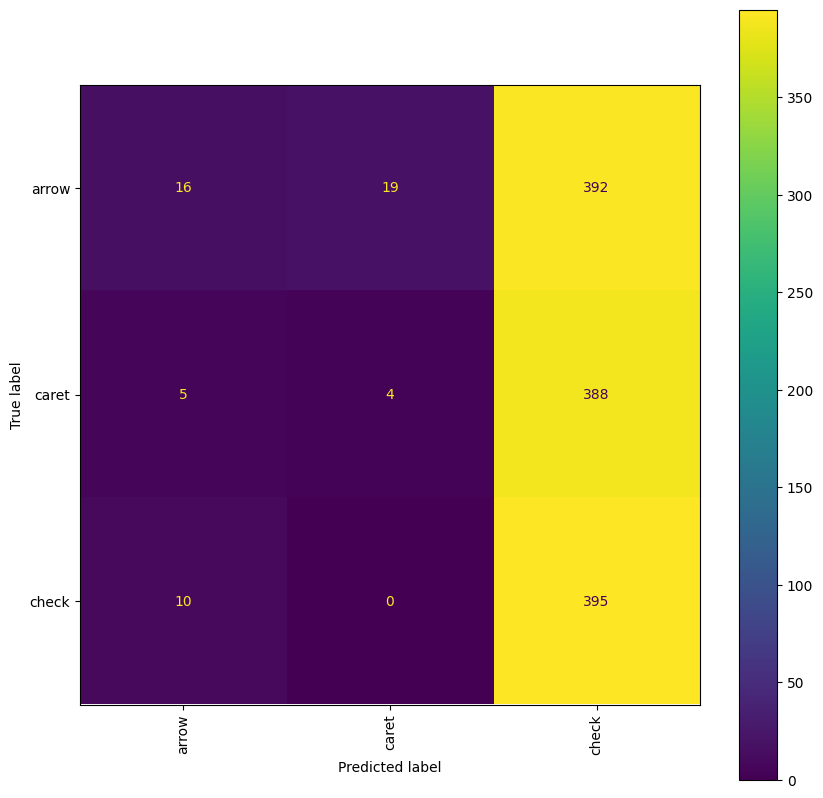

In [14]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

1/1 [==============================] - 0s 20ms/step
Label:      caret
Prediction: check


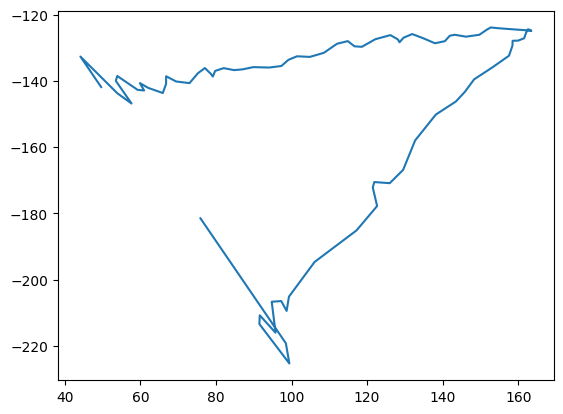

In [19]:
# lets test the model in action

test_data = random.sample(training_set, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

prediction = model.predict(np.array([sequence]))
prediction = np.argmax(prediction)

prediction_label = encoder.inverse_transform(np.array([prediction]))[0]

print('Label:     ', label)
print('Prediction:', prediction_label)